In [2]:
import os
def EXIT_NOTEBOOK(): os._exit(00)
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import torch 
from torch import nn
import torch.nn.functional as func
import seaborn as sns
import matplotlib.ticker

# ps
import pysindy as ps

# sns.set_theme()
torch.set_default_dtype(torch.float64)
plt.rcParams['text.usetex'] = True

In [ ]:
import sys; sys.path.insert(1, '../')
from SIQLib.trainNN import *
from SIQLib.Sample import *

In [4]:
class System(object):
    def __init__(self, dim, xrange=[-.02, .02], yrange=[-.02, .02], omF=1.0020): 
        self.dim    = dim
        self.xrange = xrange
        self.yrange = yrange
        self.omF    = omF
    def get_force(self,X,rho=1., mu=0.00045, gamma=33,F=1.4*10**(-5), om0=1): 
        if np.size(X.shape)==2:
            b       = np.zeros(dtype=np.float64,shape=X.shape) 
            b[:,0]= -mu*X[:,0] + ((om0**2-self.omF**2)/(2*self.omF))*X[:,1] + (3/(8*self.omF))*gamma*X[:,1]*(X[:,1]**2 + X[:,0]**2);
            b[:,1]= -mu*X[:,1] - ((om0**2-self.omF**2)/(2*self.omF))*X[:,0] - (3/(8*self.omF))*gamma*X[:,0]*(X[:,1]**2 + X[:,0]**2)-F/(2*self.omF);
        return b
    def get_exact_form(self,rho=1., mu=0.00045, gamma=33,F=1.4*10**(-5), om0=1):
        print('f1(P,Q) = %.5f P + %.5f Q + %.5f P^2 Q + %.5f Q^3' % 
              (-mu, ((om0**2-self.omF**2)/(2*self.omF)), (3/(8*self.omF))*gamma, (3/(8*self.omF))*gamma))
        print('f2(P,Q) = %.5f + %.5f P + %.5f Q + %.5f P^3 + %.5f P Q^2'%
              (-F/(2*self.omF), -((om0**2-self.omF**2)/(2*self.omF)),-mu,-(3/(8*self.omF))*gamma,-(3/(8*self.omF))*gamma,))
        
dim = 2
SYS = System(dim=dim,omF=1.0018)

In [6]:
SYS.get_exact_form()

f1(P,Q) = -0.00045 P + -0.00180 Q + 12.35277 P^2 Q + 12.35277 Q^3
f2(P,Q) = -0.00001 + 0.00180 P + -0.00045 Q + -12.35277 P^3 + -12.35277 P Q^2


# data

In [7]:
ll = np.array([0.02,0.02])
def sample_initial(n,ll,center=[0]*dim):
    X = np.random.uniform(-1,1,(n,dim))*ll + center
    if n==1: X = X[0]
    return X

In [9]:
ini  = sample_initial(200,ll)
tmp  = perform_ode(ini,SYS.get_force,T=1e5,dt=10,m=10,integrator=RK4,mode="X0")

mask_A = tmp[:,-1,0]<0
mask_B = tmp[:,-1,0]>0
state_A = tmp[mask_A][:,-1][0]
state_B = tmp[mask_B][:,-1][0]
state_A,state_B

  0%|          | 0/10000 [00:00<?, ?it/s]

(array([-0.00710054, -0.01090369]), array([ 0.00410583, -0.00117451]))

(140000, 2) (140000, 2) (3667, 2)


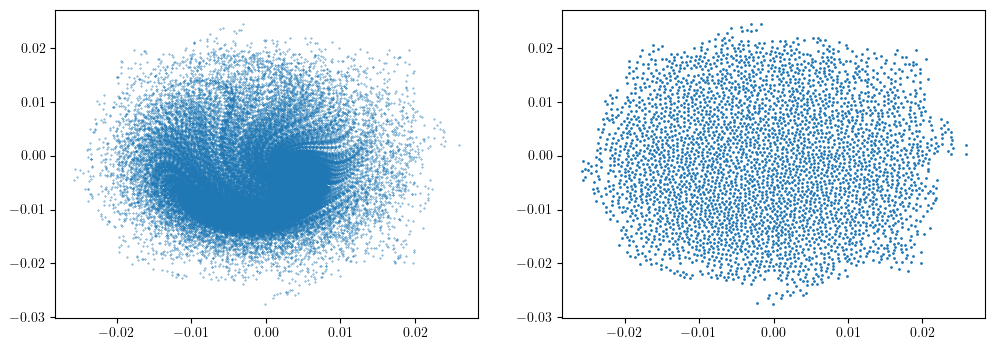

In [10]:
data_train,data_test,X0X1 = torch.load('data_2')
X,Xhat = data_train[0][:,:dim],data_train[1]
Xo = X + 0.
print(X.shape,Xo.shape,Xhat.shape)

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(X[:,0],X[:,1],s=.1)
ax[1].scatter(Xhat[:,0],Xhat[:,1],s=1)
plt.show()

# Make torch data and set the model

In [11]:
model_V = FCNN(input_dim=dim,output_dim=1,  num_hidden=3,hidden_dim=100,act=tanh).cuda()
model_g = FCNN(input_dim=dim,output_dim=dim,num_hidden=3,hidden_dim=100,act=tanh).cuda()
model   = SDE_model(model_V=model_V,model_g=model_g,dim=dim).cuda();
model.load_state_dict(torch.load("saved_models/model_ex22_"+str(.1)))

<All keys matched successfully>

# Predicting the trajectories

In [12]:
def rL2(x,y): 
    x = np.reshape(x,(len(x),-1))
    y = np.reshape(y,(len(y),-1))
    return np.sqrt( np.sum((x-y)**2,axis=-1).mean()/np.sum(x**2,axis=-1).mean() )

Int_Pars = {}
Int_Pars['dt'] = 10; Int_Pars['T'] = int(1e4); Int_Pars['m'] = 10; Int_Pars['integrator']=RK2;

In [13]:
xx     = np.linspace(SYS.xrange[0],SYS.xrange[1],501)
yy     = np.linspace(SYS.yrange[0],SYS.yrange[1],501)
XX,YY  = np.meshgrid(xx,yy)
X_unif = np.concatenate([XX[:,:,None],YY[:,:,None]],axis=-1).reshape(-1,2)

In [14]:
threshold = 6e-9

def get_V_NN(X): return model.get_V_np(X)
def get_mask(X,threshold=threshold):
    Vmin = get_V_NN(X_unif).min()
    V    = get_V_NN(X)-Vmin
    torch.cuda.empty_cache()
    return V<threshold
def get_fNN(X,model=model):
    X    = torch.tensor(X,requires_grad=True).cuda()
    _,dV = model.get_V_dV(X)
    g    = model.get_g(X)
    f    = -dV+g
    return f.cpu().data.numpy()

X0 = sample_initial(10000,ll); X0 = X0[get_mask(X0)][:1000];

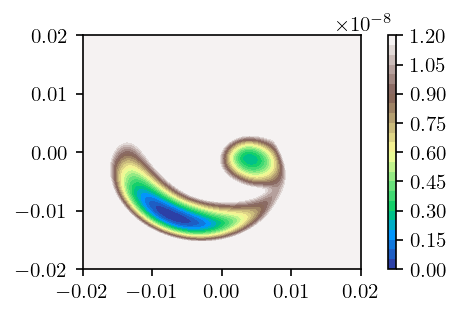

(1000, 100, 2) 	 1.95e-03 +- 9.13e-03 


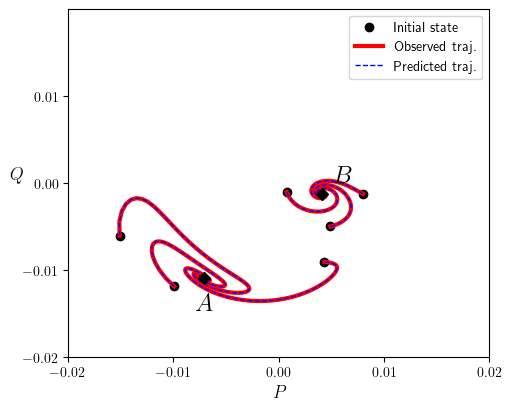

In [15]:
def Prediction_f(get_f2,X0=X0,ax=None,Int_Pars=Int_Pars,get_f1=SYS.get_force,figname=None):
    dt,T,m,integrator = Int_Pars['dt'],Int_Pars['T'],Int_Pars['m'],Int_Pars['integrator']
    exact_traj   = perform_ode(X0,get_f1,T,dt,m,num_steps=5,integrator=RK4,mode='X0',use_tqdm=False)
    learned_traj = perform_ode(X0,get_f2,T,dt,m,integrator,mode='X0',use_tqdm=False)
    errors = []
    for k in range(len(exact_traj)):
        errors.append(rL2(exact_traj[k],learned_traj[k]))
    print(exact_traj.shape,'\t %.2e +- %.2e '%(np.mean(errors),np.std(errors)))
    
    if ax==None: fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=100,constrained_layout=True)
    id1 = np.argmin(np.linalg.norm(learned_traj[:,0,:]-[0.008,-0.001],axis=-1))
    id2 = np.argmin(np.linalg.norm(learned_traj[:,0,:]-[0.001,-0.001],axis=-1))
    id3 = np.argmin(np.linalg.norm(learned_traj[:,0,:]-[0.005,-0.005],axis=-1))
    id4 = np.argmin(np.linalg.norm(learned_traj[:,0,:]-[-0.015,-0.006],axis=-1))
    id5 = np.argmin(np.linalg.norm(learned_traj[:,0,:]-[0.004,-0.009],axis=-1))
    id6 = np.argmin(np.linalg.norm(learned_traj[:,0,:]-[-0.01,-0.0115],axis=-1))
    ax.plot(learned_traj[[id1,id2,id3,id4,id5,id6],0][:,0], learned_traj[[id1,id2,id3,id4,id5,id6],0][:,1],'ko',
            markersize=6,label='Initial state')
    for kk,k in enumerate([id1,id2,id3,id4,id5,id6]):
        
        if kk==0: label = 'Observed traj.'
        else: label = None
        ax.plot(exact_traj[k,:,0],exact_traj[k,:,1],'r-',lw=3,label=label)
        
        if kk==0: label = 'Predicted traj.'
        else: label = None 
        ax.plot(learned_traj[k,:,0],learned_traj[k,:,1],'b--',lw=1,label=label)
        
    ax.set_xlim(SYS.xrange)
    ax.set_ylim(SYS.yrange)
    ax.set_xlabel(r'$P$', fontsize=13)
    ax.set_ylabel(r'$Q$', fontsize=13, rotation=1)
    ax.plot(state_A[0], state_A[1],'kD')
    ax.plot(state_B[0], state_B[1],'kD')
    ax.text(state_A[0] , state_A[1]-.003,r'$A$',fontsize=18,ha='center', va='center')
    ax.text(state_B[0]+.002,  state_B[1]+.002,r'$B$',fontsize=18,ha='center', va='center')
    ax.set_xticks([-0.02,-0.01,0,0.01,0.02])
    ax.set_yticks([-0.02,-0.01,0,0.01,])
    ax.legend(fontsize=10,loc='upper right')
    
    if figname is not None: plt.savefig(figname,dpi=300,bbox_inches='tight')
    if ax is None: plt.show()
def plot_U(get_V,fig=None,ax=None,xrange=SYS.xrange,yrange=SYS.yrange,nx=1000,ny=1000,
           threshold=1e8,get_mask=None,plot_cbar=True):
    xx     = np.linspace(xrange[0],xrange[1],nx)
    yy     = np.linspace(yrange[0],yrange[1],ny)
    XX,YY  = np.meshgrid(xx,yy)
    X_u    = np.concatenate([XX[:,:,None],YY[:,:,None]],axis=-1).reshape(-1,2)
    if dim>2: X_u    = np.hstack([X_u,[[0]*(dim-2)]*len(X_u)])
        
    if fig is None: 
        fig,ax = plt.subplots(1,1,figsize=(3,2),dpi=150,constrained_layout=True)
        if_show = True
    else:
        if_show = False
    U      = 2*get_V(X_u)
    Umin   = U.min()
    if get_mask is not None: Umin = U[get_mask(X_u)].min()
    U      = U-Umin
    U      = np.minimum(U.reshape(XX.shape),threshold)
    c      = ax.contourf(XX,YY,U,25,cmap='terrain')
    if plot_cbar:
        fmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
        fmt.set_powerlimits((1, 0))
        cbar = fig.colorbar(c,ax=ax,format=fmt,aspect=30,pad=-.15)
#         cbar.formatter.set_powerlimits((0, 0))
        cbar.ax.tick_params(labelsize=10)
    if if_show: plt.show()

plot_U(model.get_V_np,threshold=1.2e-8,get_mask=get_mask,plot_cbar=True)
Prediction_f(get_fNN)

# Input:  $\{x_i, V(x_i), DV(x_i), g(x_i)\}$=$\{x_i, V_i, DV_i, g_i\}_{1\leq i\leq N}$
# Output: $V(x)\approx basis\cdot[\xi_1,...,\xi_m]$, $DV(x)\approx basis\cdot[\phi_1,...,\phi_m]$, $g(x)\approx basis\cdot[\psi_1,...,\psi_m]$


In [16]:
def get_Y(X):
    fNN = get_fNN(X)
    VNN = model.get_V_np(X).reshape(-1,1)
    VNN = VNN-VNN.min()
    gNN = model.get_g_np(X)
    return np.hstack([fNN,VNN,gNN])
def get_G(X): return model.get_g_np(X)

X = X[get_mask(X)]

Y   = get_Y(X)
G   = get_G(X)
print(X.shape,Y.shape,G.shape)

(121747, 2) (121747, 5) (121747, 2)


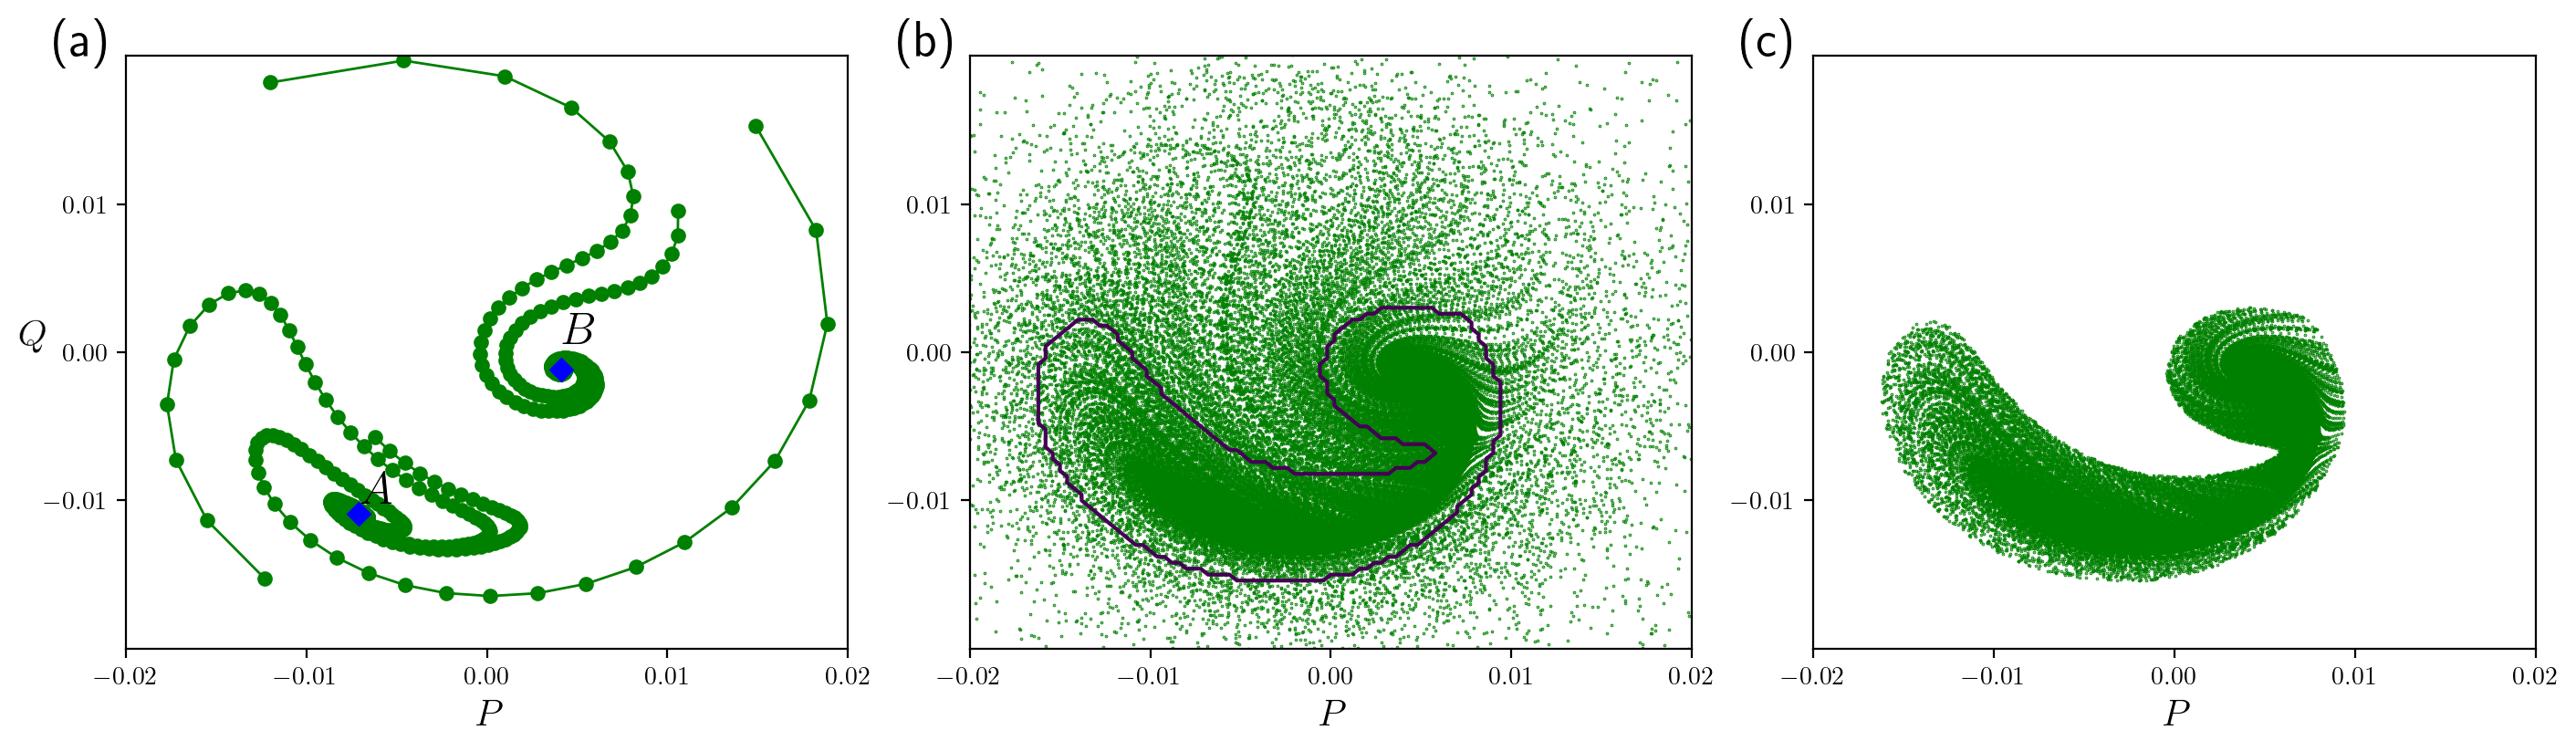

In [17]:
fig,ax = plt.subplots(1,3,figsize=(14,4),constrained_layout=True,dpi=200)

id1 = np.argmin(np.linalg.norm(X0X1[:,0,0]-[-0.0113,0.0178],axis=-1))
id2 = np.argmin(np.linalg.norm(X0X1[:,0,0]-[0.01,0.01],axis=-1))
id3 = np.argmin(np.linalg.norm(X0X1[:,0,0]-[0.015,0.015],axis=-1))
id4 = np.argmin(np.linalg.norm(X0X1[:,0,0]-[-0.012,-0.015],axis=-1))
id5 = np.argmin(np.linalg.norm(X0X1[:,0,0]-[-0.0057,-0.0056],axis=-1))

for k in [id1,id2,id3,id4,id5,]: ax[0].plot(X0X1[k,:,0,0],X0X1[k,:,0,1],'g-o',lw=1,mfc='green',markersize=5)  

ax[1].scatter(Xo[:,0],Xo[:,1],s=.1,c='g')
ax[2].scatter(X[:,0],X[:,1],s=.1,c='g')

xx     = np.linspace(SYS.xrange[0],SYS.xrange[1],101)
yy     = np.linspace(SYS.yrange[0],SYS.yrange[1],101)
XX,YY  = np.meshgrid(xx,yy)
X_u    = np.concatenate([XX[:,:,None],YY[:,:,None]],axis=-1).reshape(-1,2)
if dim>2: X_u    = np.hstack([X_u,[[0]*(dim-2)]*len(X_u)])

V      = get_V_NN(X_u)
Vmin   = V.min()

mask = get_mask(X_u)
V[mask]  = 1
V[~mask] = -1

c      = ax[1].contour(XX,YY,V.reshape(XX.shape),[0],linestyles='solid',linwidths=1,linecolors='r')

for k,ax_ in enumerate(ax.reshape(-1)):
    ax_.set_xlim(SYS.xrange[0],SYS.xrange[1])
    ax_.set_ylim(SYS.yrange[0],SYS.yrange[1])
    ax_.set_xlabel(r'$P$', fontsize=15)
    if k==0:
        ax_.set_ylabel(r'$Q$', fontsize=15, rotation=1)
        ax_.plot(state_A[0], state_A[1],'bD',label='Attractor 1')
        ax_.plot(state_B[0], state_B[1],'bD',label='Attractor 2')
        ax_.text(state_A[0]+.001 , state_A[1]+.0015,r'$A$',weight='bold',fontsize=18,ha='center', va='center')
        ax_.text(state_B[0]+.001,  state_B[1]+.0025,r'$B$',weight='bold',fontsize=18,ha='center', va='center')
    ax_.set_xticks([-0.02,-0.01,0,0.01,0.02])
    ax_.set_yticks([-0.01,0,0.01])
    ax_.tick_params(axis="both", labelsize=10)
    ax_.text(-0.1, 1.0, '(%s)'%(chr(ord('a') + k)), transform=ax_.transAxes, size=20, weight='bold')
    
plt.savefig('fig2a',dpi=400,bbox_inches = 'tight')
plt.show()

# Symbolic for V,g

In [18]:
degree_V = 4
degree_g = 3
degree   = max(degree_V,degree_g)

power = {}
k     = 0
get_k = {}
for n in range(degree+1):
    for nx in range(n,-1,-1):
        ny           = n-nx
        power[k]     = [nx,ny]
        get_k[nx,ny] = k
        k            = k + 1

In [19]:
lib_V = ps.PolynomialLibrary(degree=degree_V,include_bias=True).fit(X)
print(f"Features ({lib_V.n_output_features_}):",lib_V.get_feature_names())
print()

lib_g = ps.PolynomialLibrary(degree=degree_g,include_bias=True).fit(X)
print(f"Features ({lib_g.n_output_features_}):",lib_g.get_feature_names())
print()

optimizer_sr3_V   = ps.SR3(threshold=.2, nu=1e-2, max_iter=2000)
optimizer_sr3_g   = ps.SR3(threshold=.2, nu=1e-2, max_iter=2000)
sindy_V       = ps.SINDy(optimizer=optimizer_sr3_V,feature_library=lib_V,feature_names=['P','Q'])
sindy_g       = ps.SINDy(optimizer=optimizer_sr3_g,feature_library=lib_g,feature_names=['P','Q'])

Features (15): ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3', 'x0^4', 'x0^3 x1', 'x0^2 x1^2', 'x0 x1^3', 'x1^4']

Features (10): ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3']



In [20]:
def get_V_symbolic(X): return np.array(sindy_V.predict(X)).reshape(-1)
def get_g_symbolic(X): return np.array(sindy_g.predict(X))
def get_V_symbolic_der(X):
    x,y = X[:,0],X[:,1]
    Vx,Vy = 0,0
    for k in range(len(power)):
        if power[k][0]>=1:
            Vx = Vx + power[k][0]*sindy_V.coefficients()[0][k]*x**(power[k][0]-1)*y**power[k][1]
        if power[k][1]>=1:
            Vy = Vy + power[k][1]*sindy_V.coefficients()[0][k]*x**power[k][0]*y**(power[k][1]-1)
    return np.hstack([np.reshape(Vx,(-1,1)),np.reshape(Vy,(-1,1))])
def get_f_symbolic2(X): return -get_V_symbolic_der(X)+np.array(sindy_g.predict(X))

No. of ites: 1
V(P,Q) = 0.0000000038 1 + -0.0000008300 P + 0.0000000012 Q + 0.0000038753 P^2 + 0.0000019143 P Q + 0.0002802408 Q^2 + 0.0114813254 P^3 + 0.0194972304 P^2 Q + 0.0233209873 P Q^2 + 0.0488905089 Q^3 + 0.5244366215 P^4 + 0.9389206501 P^3 Q + 1.5636551306 P^2 Q^2 + 1.2369581039 P Q^3 + 2.0376196623 Q^4

error for V: 0.12317


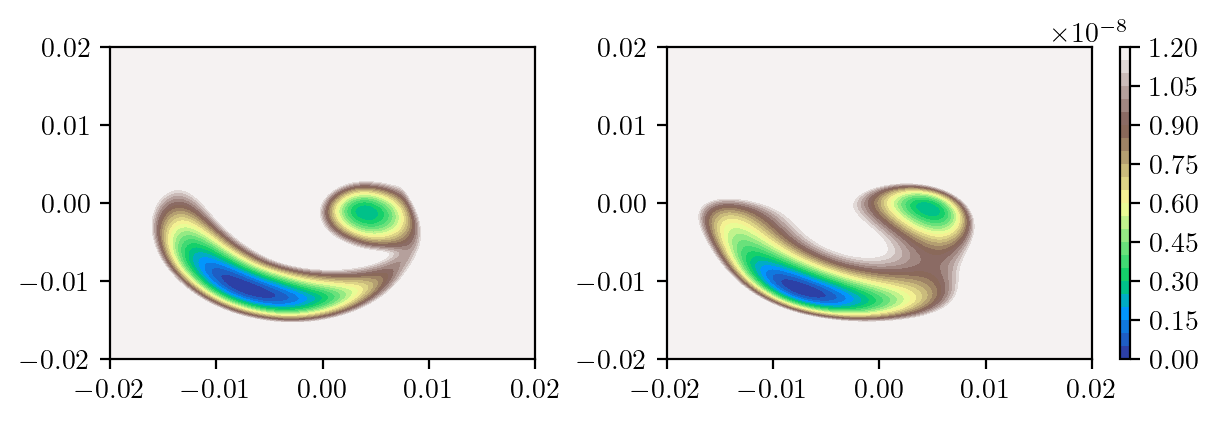

In [21]:
sindy_V.optimizer.threshold = 1e-9
sindy_V.optimizer.nu        = 1e-5
sindy_V.fit(X,x_dot=Y[:,dim]);

print('No. of ites:',sindy_V.optimizer.iters)
sindy_V.print(lhs=["V(P,Q)"],precision=10)
print()
print('error for V: %.5f' % rL2(Y[:,dim],sindy_V.predict(X)))
# print('extended error for dV: %.5f' % rL2(VDV[:,:-1],get_V_symbolic_der(X)))

fig,ax = plt.subplots(1,2,figsize=(6,2),dpi=200,constrained_layout=True)
plot_U(model.get_V_np,fig,ax[0],threshold=1.2e-8,get_mask=get_mask,plot_cbar=False)
plot_U(get_V_symbolic,fig,ax[1],threshold=1.2e-8,get_mask=get_mask,plot_cbar=True)
plt.show()

In [22]:
sindy_g.optimizer.threshold = 1e-7
sindy_g.optimizer.nu        = 1e-5
sindy_g.fit(X,x_dot=G);

print('No. of ites:',sindy_g.optimizer.iters)
sindy_g.print(lhs=["g1(P,Q)","g2(P,Q)"],precision=12)
print()
print('relative error of the regression:',rL2(G,sindy_g.predict(X)))

No. of ites: 1
g1(P,Q) = -0.000000508024 1 + -0.000458004592 P + -0.001880420501 Q + 0.027414464779 P^2 + 0.048159872492 P Q + -0.004620535787 Q^2 + 2.008191851188 P^3 + 14.613178937358 P^2 Q + 4.169228757387 P Q^2 + 11.994728901856 Q^3
g2(P,Q) = -0.000006601890 1 + 0.001764834528 P + -0.000033420802 Q + 0.011521321424 P^2 + 0.033605455226 P Q + 0.115723756448 Q^2 + -11.597261627081 P^3 + 2.690727093627 P^2 Q + -9.674556108495 P Q^2 + 6.915463939985 Q^3

relative error of the regression: 0.09201421714050695


(1000, 100, 2) 	 5.02e-02 +- 5.16e-02 


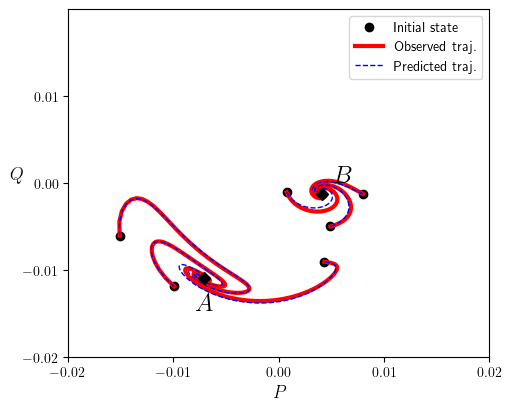

In [23]:
Prediction_f(get_f_symbolic2)

# Symbolic for fVg

In [24]:
j = 0
n_features  = len(power)
constraints = np.zeros((len(power)*dim*2,n_features*(dim+1+dim)))
for k in range(len(power)):
    nx,ny = power[k]
    
    # f1
    constraints[j,k] = 1
    if nx+ny+1<=degree_V: constraints[j,n_features*dim+get_k[nx+1,ny]] = (nx+1)
    if nx+ny<=degree_g: constraints[j,n_features*(dim+1)+k] = -1
    j = j + 1
    
    # f2
    constraints[j,n_features+k] = 1
    if nx+ny+1<=degree_V: constraints[j,n_features*dim+get_k[nx,ny+1]] = (ny+1)
    if nx+ny<=degree_g: constraints[j,n_features*(dim+2)+k] = -1
    j = j + 1
    
for k in range(len(power)):
    nx,ny = power[k]
    if nx+ny>degree_g: constraints[j,n_features*(dim+1)+k] = 1; j=j+1
    if nx+ny>degree_g: constraints[j,n_features*(dim+2)+k] = 1; j=j+1

constraints = constraints[:j]
constraints.shape,np.zeros(len(constraints)).shape

((40, 75), (40,))

In [25]:
coef_x = np.zeros(len(power))
coef_y = np.zeros(len(power))
coef_V = sindy_V.coefficients().reshape(-1)
coef_g = sindy_g.coefficients().reshape(dim,-1)
coef_g = np.hstack([coef_g,np.zeros((dim,len(power)-coef_g.shape[1]))])
for k in range(len(power)):
    nx,ny = power[k]
    if nx+ny+1<=degree_V: coef_x[k] = -(nx+1)*coef_V[get_k[nx+1,ny]]
    if nx+ny+1<=degree_V: coef_y[k] = -(ny+1)*coef_V[get_k[nx,ny+1]]
    if nx+ny<=degree_g: coef_x[k] = coef_x[k] + coef_g[0][k]
    if nx+ny<=degree_g: coef_y[k] = coef_y[k] + coef_g[1][k]
        
initial_guess_Y = np.stack([coef_x,coef_y,coef_V])
initial_guess_Y = np.vstack([initial_guess_Y,coef_g])
np.max(abs(constraints@initial_guess_Y.reshape(-1,1)))

8.046812998915853e-20

In [26]:
# initial_guess_Y = None

In [27]:
optimizer_sr3_con = ps.optimizers.constrained_sr3.ConstrainedSR3(threshold=.2, nu=1e-2, 
                        max_iter=2000,
                        initial_guess=initial_guess_Y,
                        constraint_lhs=constraints,constraint_rhs=np.zeros(len(constraints)))
sindy_total = ps.SINDy(optimizer=optimizer_sr3_con,feature_library=lib_V,feature_names=['P','Q'])

In [28]:
def get_f_from_total(X): return sindy_total.predict(X)[:,:dim]
def get_V_from_total(X): return sindy_total.predict(X)[:,dim]
def get_U_from_total(X): return 2*sindy_total.predict(X)[:,dim]

def get_dV_from_total(X):
    coef  = sindy_total.coefficients()[dim]
    x,y = X[:,0],X[:,1]
    Vx,Vy = 0,0
    for k in range(len(power)):
        if power[k][0]>=1:
            Vx = Vx + power[k][0]*coef[k]*x**(power[k][0]-1)*y**power[k][1]
        if power[k][1]>=1:
            Vy = Vy + power[k][1]*coef[k]*x**power[k][0]*y**(power[k][1]-1)
    return np.hstack([np.reshape(Vx,(-1,1)),np.reshape(Vy,(-1,1))])
def get_ndV_from_total(X): return -get_dV_from_total(X)
def get_g_from_total(X): return np.array(sindy_total.predict(X)[:,dim+1:])
def get_f_from_total2(X): return -get_dV_from_total(X)+get_g_from_total(X)

No. of ites: 0
7.464296136534945e-16

f1(P,Q) = 0.00000026 1 + -0.00046732 P + -0.00188991 Q + -0.00702931 P^2 + 0.00916546 P Q + -0.02794151 Q^2 + -0.08955463 P^3 + 11.79641699 P^2 Q + 1.04191850 P Q^2 + 10.75777080 Q^3
f2(P,Q) = -0.00000679 1 + 0.00175714 P + -0.00061794 Q + -0.00797585 P^2 + -0.01303651 P Q + -0.03094739 Q^2 + -12.53618228 P^3 + -0.43658317 P^2 Q + -13.38543042 P Q^2 + -1.23501471 Q^3
V(P,Q) = -0.00000078 P + 0.00000018 Q + 0.00000483 P^2 + 0.00000852 P Q + 0.00029164 Q^2 + 0.01148126 P^3 + 0.01949720 P^2 Q + 0.02332097 P Q^2 + 0.04889038 Q^3 + 0.52443662 P^4 + 0.93892065 P^3 Q + 1.56365513 P^2 Q^2 + 1.23695810 P Q^3 + 2.03761966 Q^4
g1(P,Q) = -0.00000051 1 + -0.00045767 P + -0.00188138 Q + 0.02741448 P^2 + 0.04815986 P Q + -0.00462054 Q^2 + 2.00819185 P^3 + 14.61317894 P^2 Q + 4.16922876 P Q^2 + 11.99472890 Q^3
g2(P,Q) = -0.00000661 1 + 0.00176566 P + -0.00003467 Q + 0.01152135 P^2 + 0.03360542 P Q + 0.11572374 Q^2 + -11.59726163 P^3 + 2.69072709 P^2 Q + -9.6745561

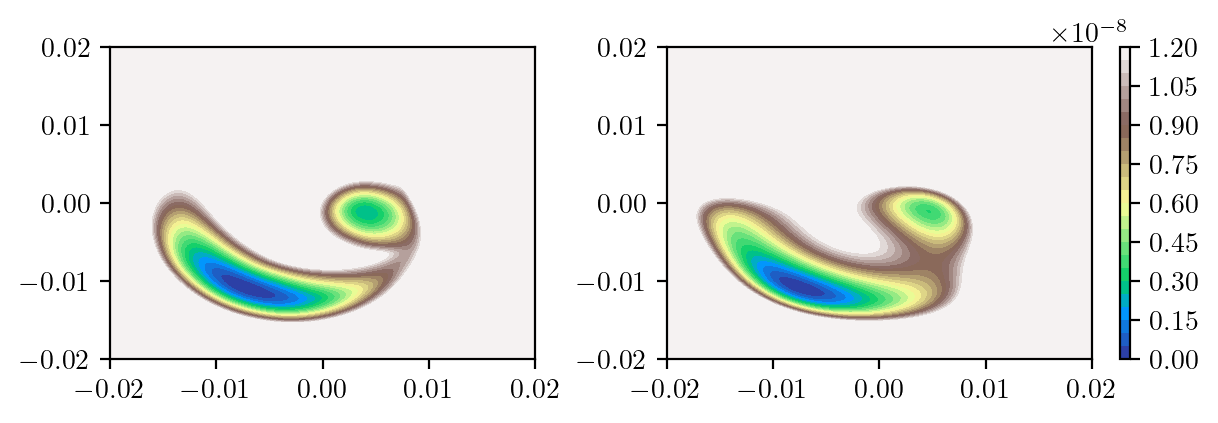

In [29]:
sindy_total.optimizer.threshold = 1e-9
sindy_total.optimizer.nu        = 1e-2
sindy_total.fit(X,x_dot=Y);

print('No. of ites:',sindy_total.optimizer.iters)
def l2_norm(X): return np.sqrt(np.mean(X**2))
print(l2_norm(constraints@sindy_total.coefficients().reshape(-1,1)))
print()
sindy_total.print(lhs=["f1(P,Q)","f2(P,Q)","V(P,Q)","g1(P,Q)","g2(P,Q)"],precision=8)
print()
print('relative error of the regression:',rL2(Y,sindy_total.predict(X)))

print('extended error for f: %.5f' % rL2(Y[:,:dim],get_f_from_total(X)))
print('extended error for V: %.5f' % rL2(Y[:,dim], get_V_from_total(X)))
print('extended error for g: %.5f' % rL2(Y[:,dim+1:],get_g_from_total(X)))

fig,ax = plt.subplots(1,2,figsize=(6,2),dpi=200,constrained_layout=True)
plot_U(model.get_V_np,fig,ax[0],threshold=1.2e-8,get_mask=get_mask,plot_cbar=False)
plot_U(get_V_from_total,fig,ax[1],threshold=1.2e-8,get_mask=get_mask,plot_cbar=True)
plt.show()

In [30]:
def write_form2(coef,power,var):
    for k in range(min(len(power),len(coef))):
        term = ''
        if power[k][0]==1: term = term + '%s'%(var[0])
        if power[k][0]>1: term = term + '%s^%d'%(var[0],power[k][0])
        if power[k][1]==1: term = term + '%s'%(var[1])
        if power[k][1]>1: term = term + '%s^%d'%(var[1],power[k][1])
#         print(term)
        tmp = '%10.3e'%abs(coef[k])
        if coef[k]>1e-10: print('+ '+tmp[:-4]+'\\times 10^{%d}'%int(tmp[-3:])+' '+term,end=' ')
        if coef[k]<-1e-10: print('- '+tmp[:-4]+'\\times 10^{%d}'%int(tmp[-3:])+' '+term,end=' ')
    print()

In [31]:
coef = sindy_total.coefficients()[2]*2
write_form2(coef,power,var=['P','Q'])

coef = sindy_total.coefficients()[3]
write_form2(coef,power,var=['P','Q'])
coef = sindy_total.coefficients()[4]
write_form2(coef,power,var=['P','Q'])

+  8.122\times 10^{-9}  -  1.555\times 10^{-6} P +  3.582\times 10^{-7} Q +  9.653\times 10^{-6} P^2 +  1.705\times 10^{-5} PQ +  5.833\times 10^{-4} Q^2 +  2.296\times 10^{-2} P^3 +  3.899\times 10^{-2} P^2Q +  4.664\times 10^{-2} PQ^2 +  9.778\times 10^{-2} Q^3 +  1.049\times 10^{0} P^4 +  1.878\times 10^{0} P^3Q +  3.127\times 10^{0} P^2Q^2 +  2.474\times 10^{0} PQ^3 +  4.075\times 10^{0} Q^4 
-  5.148\times 10^{-7}  -  4.577\times 10^{-4} P -  1.881\times 10^{-3} Q +  2.741\times 10^{-2} P^2 +  4.816\times 10^{-2} PQ -  4.621\times 10^{-3} Q^2 +  2.008\times 10^{0} P^3 +  1.461\times 10^{1} P^2Q +  4.169\times 10^{0} PQ^2 +  1.199\times 10^{1} Q^3 
-  6.610\times 10^{-6}  +  1.766\times 10^{-3} P -  3.467\times 10^{-5} Q +  1.152\times 10^{-2} P^2 +  3.361\times 10^{-2} PQ +  1.157\times 10^{-1} Q^2 -  1.160\times 10^{1} P^3 +  2.691\times 10^{0} P^2Q -  9.675\times 10^{0} PQ^2 +  6.915\times 10^{0} Q^3 


In [32]:
SYS.get_exact_form()

# f1(P,Q) = 0.00000068 1 + -0.00054189 P + -0.00176480 Q 
# + -0.01064278 P^2 + -0.00584547 P Q + -0.01758222 Q^2 
# + 0.04122334 P^3 + 11.15659122 P^2 Q + 0.40408904 P Q^2 
# + 11.00477724 Q^3

# f2(P,Q) = -0.00000681 1 + 0.00176379 P + -0.00060503 Q 
# + -0.00870116 P^2 + -0.01582180 P Q + -0.02713552 Q^2 
# + -12.62856650 P^3 + -0.55719208 P^2 Q + -13.65411637 P Q^2 
# + -1.00107424 Q^3

f1(P,Q) = -0.00045 P + -0.00180 Q + 12.35277 P^2 Q + 12.35277 Q^3
f2(P,Q) = -0.00001 + 0.00180 P + -0.00045 Q + -12.35277 P^3 + -12.35277 P Q^2


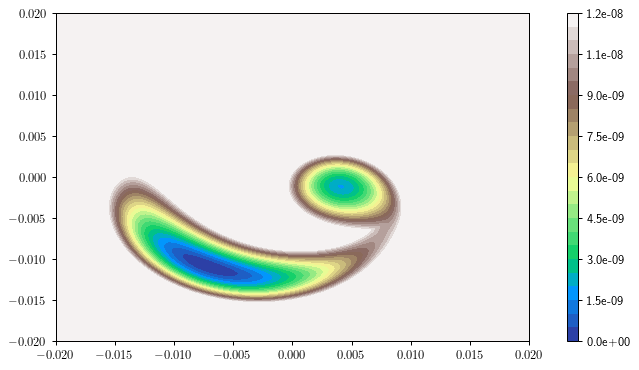

In [33]:
import scipy.io as sio
data=sio.loadmat('meshV1p0018.mat')

def plot_mesh_results(fig,ax,threshold=1e8,plot_cbar=True):
    xx     = np.linspace(-0.02,0.02,1000)
    yy     = np.linspace(-0.02,0.02,1000)
    XX,YY  = np.meshgrid(xx,yy)
    X_u    = np.concatenate([XX[:,:,None],YY[:,:,None]],axis=-1).reshape(-1,2)
    U      = data['meshV1p0018'].reshape(-1)*2
    Umin   = U[~np.isnan(U)].min()
    U      = U-Umin
    U[np.isnan(U)] = threshold
    U      = np.minimum(U.reshape(XX.shape),threshold)
    c      = ax.contourf(YY,XX,U,25,cmap='terrain')
    if plot_cbar:
        cbar = fig.colorbar(c,ax=ax,format='%.1e',aspect=30)
        cbar.ax.tick_params(labelsize=10)

fig,ax = plt.subplots(1,1,figsize=(7,4),constrained_layout=True,dpi=90)
plot_mesh_results(fig,ax,threshold=1.2e-8,plot_cbar=True)

In [34]:
def get_mask2(X,threshold=1e-8):
    Vmin = get_V_NN(X_unif).min()
    V    = get_V_NN(X)-Vmin
    torch.cuda.empty_cache()
    return V<threshold
def plot_vectorfield(get_g,fig,ax,xrange=SYS.xrange,yrange=SYS.yrange,nx=101,ny=101,get_mask=None):
    xx     = np.linspace(xrange[0],xrange[1],nx)
    yy     = np.linspace(yrange[0],yrange[1],ny)
    XX,YY  = np.meshgrid(xx,yy)
    X_u    = np.concatenate([XX[:,:,None],YY[:,:,None]],axis=-1).reshape(-1,2)
    if dim>2: X_u    = np.hstack([X_u,[[0]*(dim-2)]*len(X_u)])
    
    UU     = np.array(get_g(X_u)[:,0])
    VV     = np.array(get_g(X_u)[:,1])
    
    speed = np.sqrt(UU**2 + VV**2).reshape(XX.shape)
    lw = 5*speed / speed.max()
#     print(lw)
    
    if get_mask is not None: 
        mask = get_mask(X_u)
        lw = 5*speed / speed.reshape(-1)[mask].max()
        UU[~mask]=np.nan; VV[~mask]=np.nan
    UU = UU.reshape(XX.shape)
    VV = VV.reshape(XX.shape)
    
    ax.streamplot(XX,YY,UU,VV, density=1.5, color='k', linewidth=lw)   
def plot_U(get_V,fig,ax,xrange=SYS.xrange,yrange=SYS.yrange,nx=501,ny=501,threshold=1e8,get_mask=None,plot_cbar=True):
    xx     = np.linspace(xrange[0],xrange[1],nx)
    yy     = np.linspace(yrange[0],yrange[1],ny)
    XX,YY  = np.meshgrid(xx,yy)
    X_u    = np.concatenate([XX[:,:,None],YY[:,:,None]],axis=-1).reshape(-1,2)
    if dim>2: X_u    = np.hstack([X_u,[[0]*(dim-2)]*len(X_u)])

    U      = 2*get_V(X_u)
    Umin   = U.min()
    if get_mask is not None: Umin = U[get_mask(X_u)].min()
    U      = U-Umin
    U      = np.minimum(U.reshape(XX.shape),threshold)
    c      = ax.contourf(XX,YY,U,25,cmap='terrain')
    
    if plot_cbar:
        fmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
        fmt.set_powerlimits((1, 0))
        cbar = fig.colorbar(c,ax=ax,format=fmt,aspect=30,pad=-.05)
#         cbar.formatter.set_powerlimits((0, 0))
        cbar.ax.tick_params(labelsize=10)

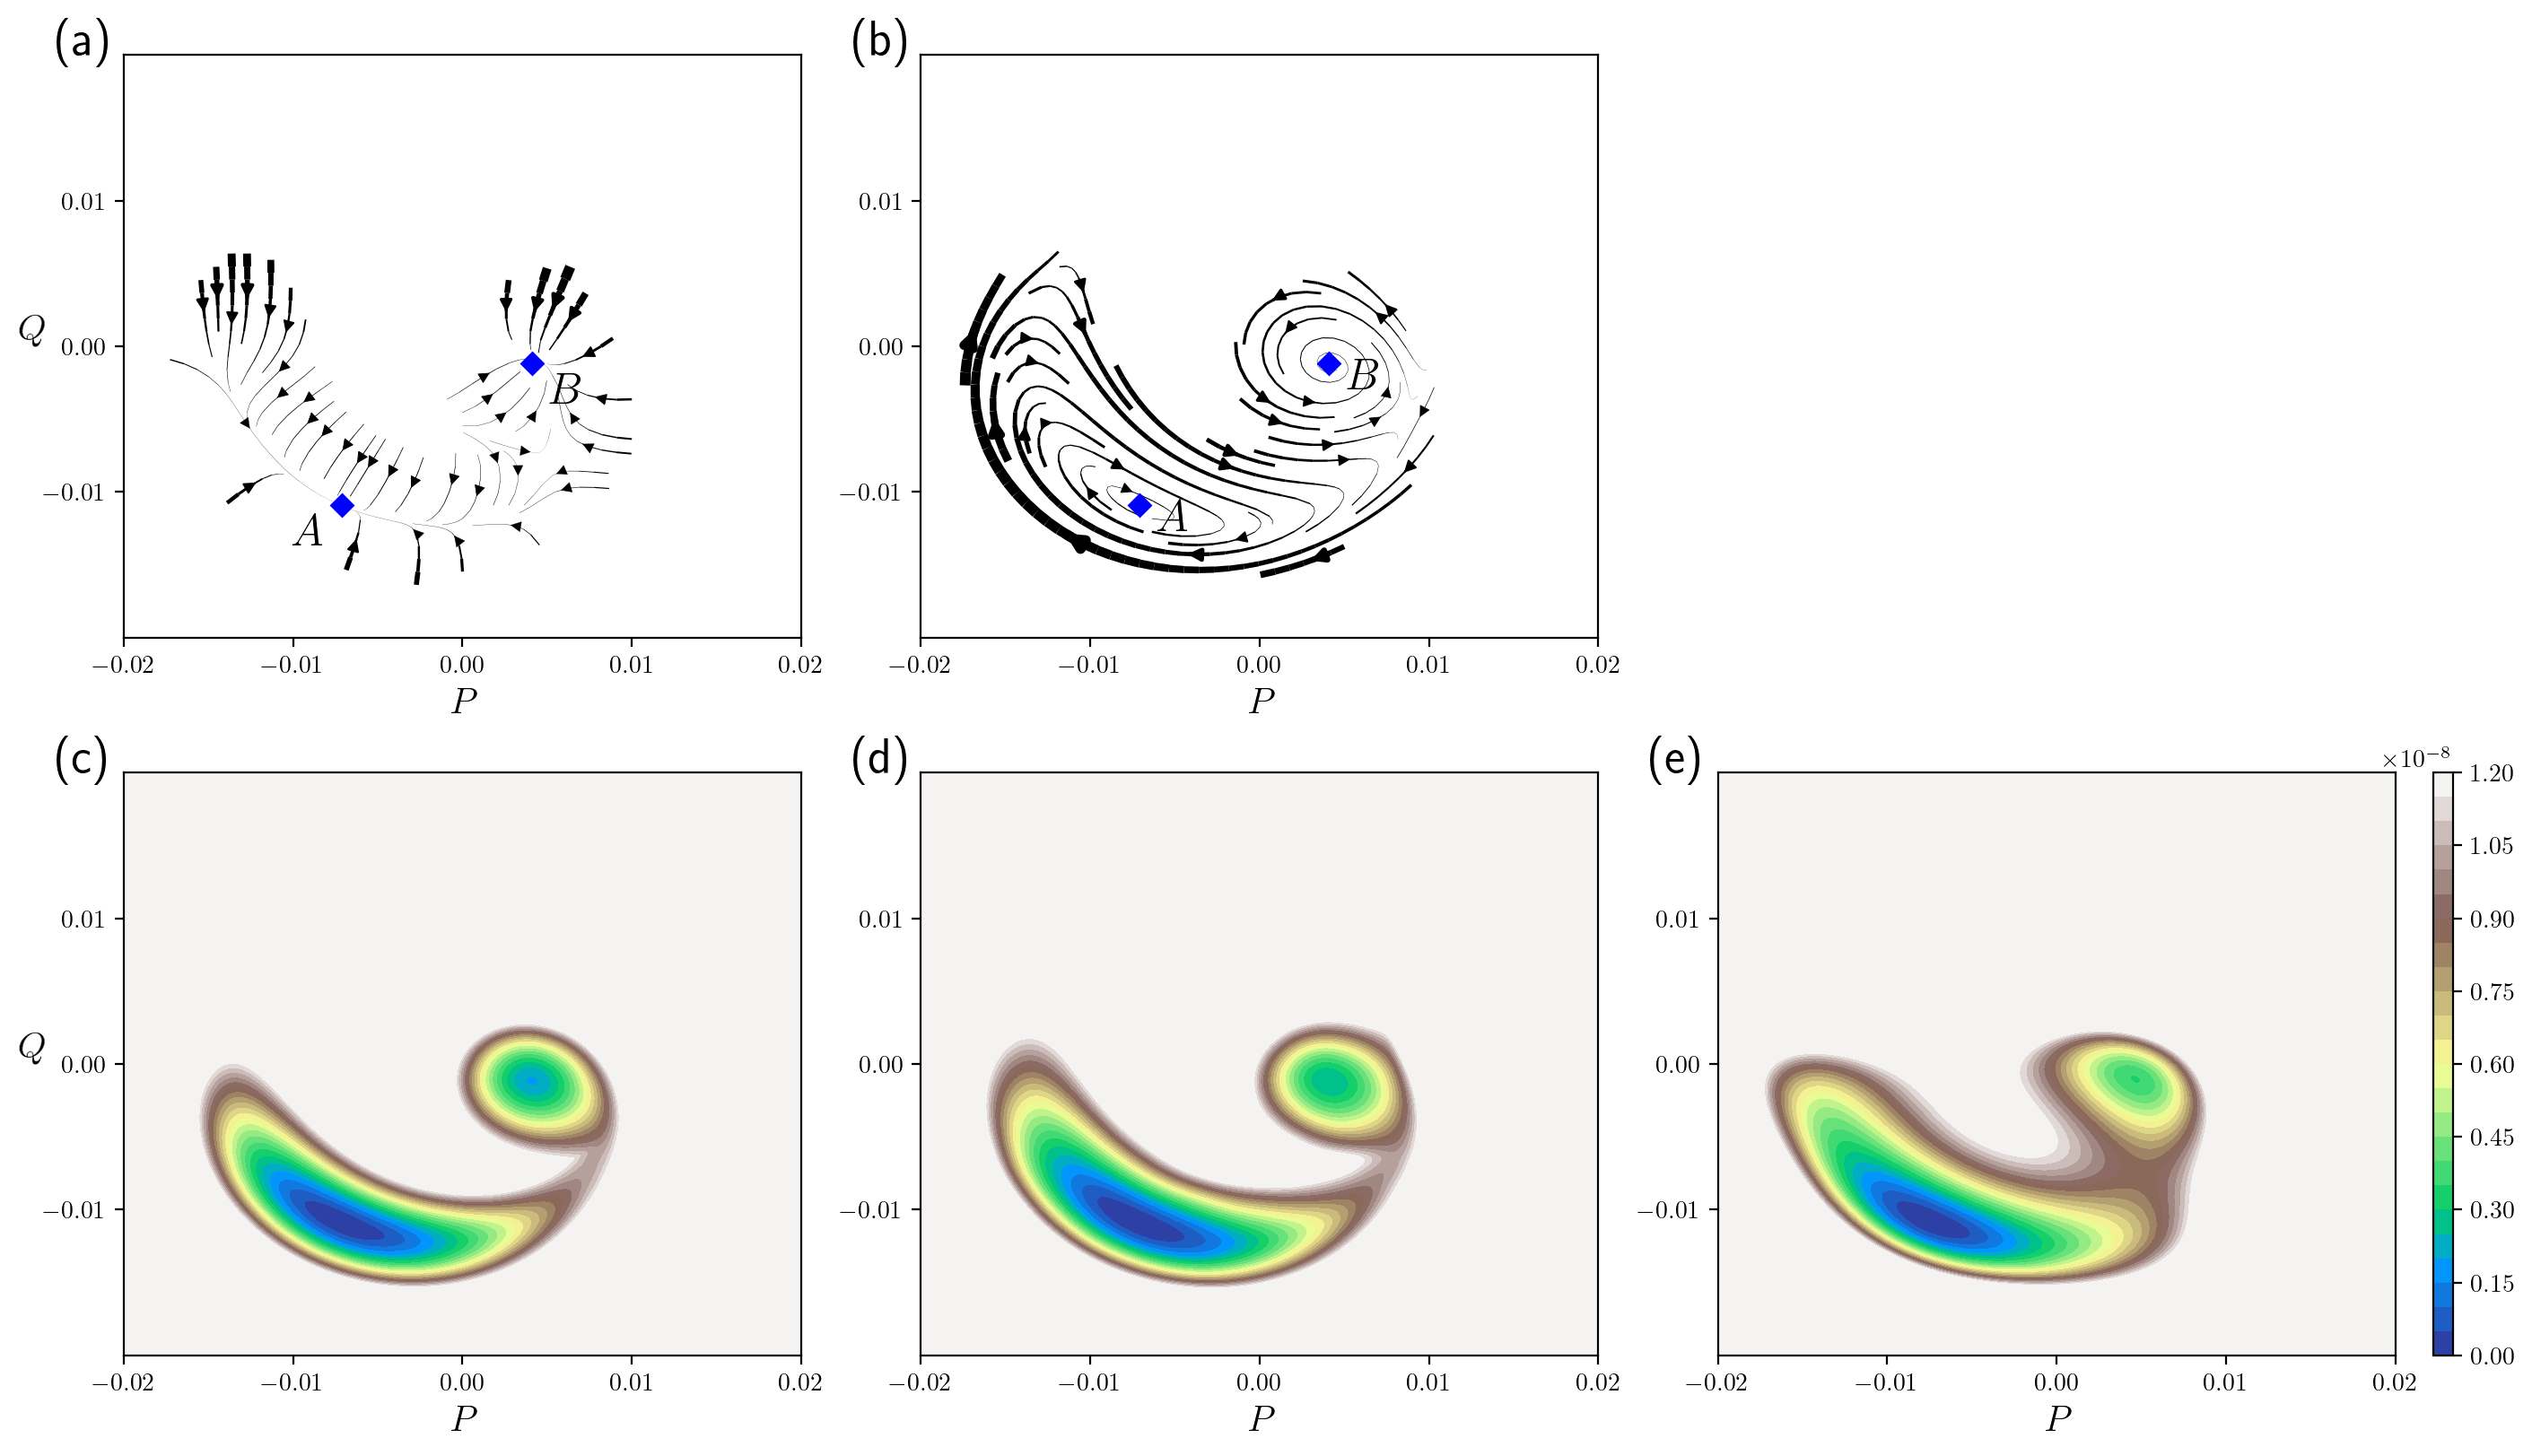

In [35]:
fig,ax = plt.subplots(2,3,figsize=(14,8),constrained_layout=True,dpi=200)

plot_vectorfield(get_ndV_from_total,fig,ax[0,0],get_mask=get_mask2)
plot_vectorfield(get_g_from_total,fig,ax[0,1],get_mask=get_mask2)

plot_mesh_results(fig,ax[1,0],threshold=1.2e-8,plot_cbar=False)
plot_U(get_V_NN,fig,ax[1,1],threshold=1.2e-8,get_mask=get_mask,plot_cbar=False)
plot_U(get_V_from_total,fig,ax[1,2],threshold=1.2e-8,get_mask=get_mask,plot_cbar=True)

for k,ax_ in enumerate(ax.reshape(-1)[[0,1,3,4,5]]):
    ax_.set_xlim(SYS.xrange[0],SYS.xrange[1])
    ax_.set_ylim(SYS.yrange[0],SYS.yrange[1])
    ax_.set_xlabel(r'$P$', fontsize=15)
    if k==0 or k==2: ax_.set_ylabel(r'$Q$', fontsize=15, rotation=1)
    if k==0:
        ax_.plot(state_A[0], state_A[1],'bD',label='Attractor 1')
        ax_.plot(state_B[0], state_B[1],'bD',label='Attractor 2')
        ax_.text(state_A[0]-.002 , state_A[1]-.002,r'$A$',fontsize=18,ha='center', va='center')
        ax_.text(state_B[0]+.002,  state_B[1]-.002,r'$B$',fontsize=18,ha='center', va='center')
    if k==1:
        ax_.plot(state_A[0], state_A[1],'bD',label='Attractor 1')
        ax_.plot(state_B[0], state_B[1],'bD',label='Attractor 2')
        ax_.text(state_A[0]+.002 , state_A[1]-.001,r'$A$',fontsize=18,ha='center', va='center')
        ax_.text(state_B[0]+.002,  state_B[1]-.001,r'$B$',fontsize=18,ha='center', va='center')
    #     ax[k].plot(.0065,-.01,'bo',markersize=2)
    ax_.set_xticks([-0.02,-0.01,0,0.01,0.02])
    ax_.set_yticks([-0.01,0,0.01])
    ax_.tick_params(axis="both", labelsize=10)
    ax_.text(-0.1, 1.0, '(%s)'%(chr(ord('a') + k)), transform=ax_.transAxes, size=20, weight='bold')

ax[0,2].axis('off')
plt.savefig('fig2b_',dpi=400,bbox_inches = 'tight')
plt.show()